In [3]:
import Pkg
Pkg.activate("..")

using SCPToolbox
using DifferentialEquations
using Contour
using Colors, LinearAlgebra, Latexify, Symbolics
import Plots, Measures
using Plots, Measures

# Import the different possible low-level convex solvers
using ECOS
# using Mosek
# using MosekTools
# using Clarabel
# using Ipopt
# using SCS
# using OSQP

  Activating project at `C:\Users\thatf\OneDrive\Documents\Purdue Classes\AAE 590ACA\AAE590ACA-Stochastic-SCP-Rocket-Landing\SCPToolbox`


#### Resources

[Convex Optimization for Trajectory Generation: A Tutorial](https://ieeexplore.ieee.org/document/9905530) was referenced heavily while making this. If you have any questions or want to know more details, look at that journal article. The code uses the following Github repository associated with the journal article [SCPToolbox](https://github.com/UW-ACL/SCPToolbox.jl/).

## Model Derivation

### Problem Description

#### General Description

Land a vehicle propelled by an electric fan using thrust vectoring.

#### Assumptions

* Rigid body dynamics
* There is no control delay (could be relaxed in future)
* No uncertainties in dynamics

#### States

In [1]:
r = Symbolics.variables(:r, 1:2)
v = Symbolics.variables(:v, 1:2)
@variables θ
@variables ω

x = [r; v; θ; ω];

LoadError: UndefVarError: `Symbolics` not defined

The state vector is
$$
x = `{julia} latexify(x)`
$$

(Ignore the $L"$ $"$)

#### Controls

In [4]:
T = Symbolics.variables(:T, 1:2)
@variables T_mag 

u = [T; T_mag];

The control vector is
$$
u = `{julia} latexify(u)`
$$
where $\vec T$ is the thrust vector in the body frame, $\sigma$ is the magnitude of the thrust (needed to be able to have certain input constraints), and $\gamma$ is the angle of the thrust vanes.

#### Parameters

In [5]:
@variables t_f

p = [t_f];

The parameter vector is
$$
p = `{julia} latexify(p)`
$$
where $t_f$ is the time when landing occurs.

#### Constraints

There are two types of constraints. Path is the general term for the state and control.

1. Convex Path Constraints

Constraints which constraint the path to be apart of a closed and bounded convex set.
These can be transformed into constraining the path to be inside some convex cone.

|    Label        | Notation     |     Name      | Definition |
|:---------------:|:----:|:-------------:|:----------:|
|`UNCONSTRAINED`|  $\mathbb{K}_{ \lesseqgtr}$ | Unconstrained cone  |  $$\{x\in\mathbb{R}^n\}$$ |
|`ZERO`|  $\mathbb{K}_{=0}$ | Zero cone | $\{x\in\mathbb{R}^n\mid x=0\}$   |
|`NONPOS`|  $\mathbb{K}_{\leq 0}$ | Non-positive orthant  | $\{x\in\mathbb{R}^n\mid x\leq 0\}$|
|`L1` | $\mathbb{K}_{1}$ | $l_1$ norm cone| $\{(t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \lVert x\rVert_1\leq t\}$ |
|`SOC`| $\mathbb{K}_{2}$ | $l_2$ norm cone| $\{(t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \lVert x\rVert_2\leq t\}$ |
|`LINF`| $\mathbb{K}_{\infty}$ |  $l_\infty$ norm cone |  $\{(t,x)\in\mathbb{R}\times\mathbb{R}^n\mid \lVert x\rVert_\infty\leq t\}$ |
|`EXP`|  $\mathbb{K}_{\text{EXP}}$ | Exponential cone | $\{(x,y,z)\in \mathbb{R}\times \mathbb{R} \times \mathbb{R} \mid y\,\text{exp}(x/y) \leq z,~y>0\}$ |

2. Nonconvex Path Constraints

Constraints which are too complex to be transformed into a set of convex cone constraints.
SCP handles these by linearizing them.

**State**

1. Glideslope 
\begin{equation*}
\left\{r\in\mathbb{R}^2~|~ ||\vec r|| \cos(\gamma_{gs}) \leq e_2^\top r\right\}
\end{equation*}
\begin{equation*}
\left\{r\in\mathbb{R}^2~|~ ||\vec r|| \cos(\gamma_{gs}) \leq r_2 \right\}
\end{equation*}
\begin{equation*}
\left\{r\in\mathbb{R}^2~|~ ||\vec r|| \leq \frac{r_2}{\cos(\gamma_{gs})} \in \mathbb{K}_{2} \right\}
\end{equation*}

In [311]:
#@variables γ_gs
## Constants for state constraints
#csc = [γ_gs]

# State Constraint Constant
γ_gs_ = deg2rad(20.0); # [rad] Glideslope angle (measured from the horizon)
tf_min = 15 # use tf_guess instead? more accurate lower bound...

# Define constraints
# Glideslope - replace with half space? (if relaxing landing site bc)
#glideslope(r, clp) = @add_constraint(clp, L1, r -> [r[2]/tan(γ_gs_); r[1]])
glideslope(r, clp) = @add_constraint(clp, SOC, r -> [r[2] / cos(pi/2 - γ_gs_); r])

state_constraints(t, k, x, p, pbm, clp) = begin
        r, v, θ, ω = x[1:2], x[3:4], x[5], x[6]

        @add_constraint(clp, NONPOS, p -> tf_min - p[1])
        glideslope(r, clp)
    end;

**Control**

1. Thrust cone
\begin{equation*}
\left\{δ\in\mathbb{R}~|~ |δ| \leq δ_{max} \in \mathbb{K}_{1} \right\}
\end{equation*}

2. Thrust limit
\begin{equation*}
\left\{T\in\mathbb{R}~|~ T \leq T_{max} \right\}
\end{equation*}
Rewritting to use the nonpositive cone,
\begin{equation*}
\left\{T\in\mathbb{R}~|~ T - T_{max} \leq 0 \in \mathbb{K}_{\leq 0} \right\}
\end{equation*}

In [312]:
# Control Constraint Constants
#T_max_ = 13.26 # [kg km / s2] Maximum thrust
#T_min_ = 4.97 # [kg km / s2] Minimum thrust
#δ_max_ = deg2rad(8.0); # [rad] Maximum gimbal angle

T_max_ = 500e3 # [N] Maximum thrust
T_min_ = 100e3 # [N] Maximum thrust
δ_max_ = deg2rad(7.0); # [rad] Maximum gimbal angle

# Define constraints
thrust_limit(T_mag, clp) = @add_constraint(clp, NONPOS, T_mag -> T_mag - T_max_)
thrust_lower_limit(T_mag, clp) = @add_constraint(clp, NONPOS, T_mag -> T_min_ - T_mag)

# Thrust Cone
thrust_cone(u, clp) = @add_constraint(clp, NONPOS, "Thrust Cone", u -> u[3] - u[1] / cos(δ_max_))

# LCVX
lcvx_thrust_equality(T, T_mag, clp) = @add_constraint(clp, SOC, "lcvx_equality_thrust_cone", (T, T_mag) -> [T_mag; T]);

control_constraints(t, k, u, p, pbm, clp) = begin
        T, T_mag = u[1:2], u[3]
                
        thrust_limit(T_mag, clp)
        thrust_lower_limit(T_mag, clp)
        thrust_cone(u, clp)
        lcvx_thrust_equality(T, T_mag, clp)
    end;

**Parameter**

1. Final time range 
\begin{equation*}
\left\{t_f\in\mathbb{R}~|~ t_{fmin} \leq t_f \right\}
\end{equation*}

#### Constants

In [313]:
# Environment Parameters
#@variables g
#g_ = 3.7114e-3; # [km/s^2] Earth gravity


# Mechanical Parameters
#@variables m
#m_ = 2600 # [kg] Initial mass

#@variables L
#L_ = 3e-3 # [km] Thrust lever arm

#@variables J
#J_t = 15000 * (1e-3) ^ 2; # [kg*m^2] Moment of inertia#
#J_ = [J_t];

# Environment Parameters
@variables g
g_ = 9.81; # [m/s^2] Earth gravity


# Mechanical Parameters
@variables m
m_ = 25e3 # [kg] Initial mass

@variables L
L_ = 1 # [m] Thrust lever arm

@variables J
J_t = 100e4; # [kg*m^2] Moment of inertia
J_ = [J_t];


# General Constant Vector
c = [g; m; L; J]
c_ = [g_; m_; L_; J_];

The constants are

$$c = \begin{bmatrix} g \\ m \\ L \\ J \end{bmatrix} = `{julia} latexify(c_)`$$

#### Boundary Conditions

In [344]:
km2m(x) = x*1e3 # Conversion from km to m
kph2mps(v) = v/3.6 # Conversion from km/h to m/s

# Initial state
r0 = Symbolics.variables(:r_0, 1:2)
r0_ = km2m([1.5, 2]) # [m]

v0 = Symbolics.variables(:v_0, 1:2)
v0_ = kph2mps.([80, -80]) # [m / s] [-0.0185; -0.0247]

θ0 = Symbolics.variables(:θ_0, 1)
θ0_ = deg2rad.([90]) # [rad]

ω0 = Symbolics.variables(:ω_0, 1)
ω0_ = deg2rad.([0]) # [rad / s]

x0 = [r0; v0; θ0; ω0]
x_0 = [r0_; v0_; θ0_; ω0_];

# Terminal state
r1 = zeros(2) # Potentially relax this constraint into the objective function - would have to change glideslope to be centered at new final position...
v1 = zeros(2)
θ1 = deg2rad(90)
ω1 = zeros(1)

x1 = [r1; v1; θ1; ω1];

g_ic = x - x0
g_tc = x - x1

6-element Vector{Num}:
 r₁
 r₂
 v₁
 v₂
 -1.5707963267948966 + θ
  ω

The boundary conidtions are
$$g_{ic}(x(0), p) = `{julia} latexify(x - x_0)` = \vec 0$$

$$g_{tc}(x(1), p) = `{julia} latexify(g_tc)` = \vec 0$$

### Equations of Motions
#### Euler's Law
$$
\begin{cases}
\dot\omega_1 = \frac{M_1 + (I_2 - I_3)\omega_2\omega_3}{I_1} \\
\dot\omega_2 = \frac{M_2 + (I_3 - I_1)\omega_3\omega_1}{I_2} \\
\dot\omega_3 = \frac{M_3 + (I_1 - I_2)\omega_1\omega_2}{I_3} \\
\end{cases}
$$

Which under the assumptions that the roll rate is negligible reduces to
$$\vec\omega = \frac{\vec M}{I}$$

#### Newton's Second Law
$$\vec F = m \vec a$$

#### Control Model
Acceleration:
$$\vec a_u = C_{eb} \frac{\vec T}{m}$$
where $\vec a_u$ is the acceleration from the control, $C_{eb}$ is the rotation matrix from the body to the Earth frame

Moment:
$$\vec M = - L \hat b_1 \times \vec  T$$

### Dynamics

The equation of motion is $\dot{x} = f(t, x(t), u(t), p) =$

In [345]:
x_dot = v
Rxθ = [cos(θ) -sin(θ); 
        sin(θ) cos(θ)]
C_be = Rxθ
C_eb = Rxθ'
T_e = C_be * T
v_dot = T_e / m - [0, g]
θ_dot = ω
M = -L * T[2]
ω_dot =  M / J
f_ = [x_dot; v_dot; θ_dot; ω_dot]

6-element Vector{Num}:
                               v₁
                               v₂
      (T₁*cos(θ) - T₂*sin(θ)) / m
 -g + (T₁*sin(θ) + T₂*cos(θ)) / m
                                ω
                      (-L*T₂) / J

### Cost Function

Assuming Bolza Form of the cost function:

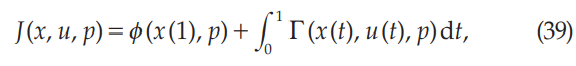

#### Terminal Cost $\phi(x(1), p)$

Final Time: $\frac{t_f}{t_{fguess}}$ 

$$\phi(x(1),p) = \frac{t_f}{t_{fguess}}$$

In [346]:
ϕ(x, p) = p[1] / tf_guess;

#### Running Cost $\Gamma(x(t), u(t), p)$

Thrust: $\frac{T}{T_{max}}$

$$\Gamma(x(t),u(t),p) = \frac{T}{T_{max}} + (\frac{0.1 \delta}{\delta_{max}})^2$$

In [347]:
Γ(x, u, p) = u[3] / T_max_;

#### Cost Function

$$J(x,u,p) = \frac{t_f}{t_{fguess}} + \int_{t_i}^{t_f}\frac{T}{T_{max}} + (\frac{0.1 \delta}{\delta_{max}})^2 dt$$

## SCP Problem Definition

SCP: Successive Convex Programming

### Optimal Control Optimization Problem Definition

#### General Form

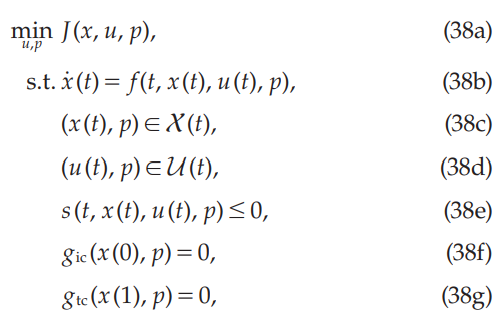

where $\mathcal{X}$ is the set of states that satisfy the convex state constraints, $\mathcal{U}$ is the set of controls that satisfy the convex control constraints, $s(t, x(t), u(t), p)$ is the nonconvex path constraint, $g_{ic}$ is the initial condition, and $g_{tc}$ is the terminal condition.

### SCP Optimization Problem Definition

Scale the dynamics by the final time so that the final time can be a free parameter.

In [348]:
f_n = f_ * t_f

6-element Vector{Num}:
                                    t_f*v₁
                                    t_f*v₂
           ((T₁*cos(θ) - T₂*sin(θ))*t_f) / m
 (-g + (T₁*sin(θ) + T₂*cos(θ)) / m)*t_f
                                    t_f*ω
                             (-L*T₂*t_f) / J

State: $A = \nabla_x f =$

In [349]:
A_l = Symbolics.jacobian(f_n, x)

6×6 Matrix{Num}:
 0  0  t_f   0                              0         0
 0  0   0   t_f                             0         0
 0  0   0    0   ((-T₁*sin(θ) - T₂*cos(θ))*t_f) / m   0
 0  0   0    0    ((T₁*cos(θ) - T₂*sin(θ))*t_f) / m   0
 0  0   0    0                              0        t_f
 0  0   0    0                              0         0

Control: $B = \nabla_u f =$

In [350]:
B_l = Symbolics.jacobian(f_n, u)

6×3 Matrix{Num}:
   0                    0               0
   0                    0               0
 (t_f*cos(θ)) / m    (-t_f*sin(θ)) / m  0
 (t_f*sin(θ)) / m     (t_f*cos(θ)) / m  0
   0                    0               0
   0               (-L*t_f) / J         0

Parameter: $F = \nabla_p f =$

In [351]:
F_l = Symbolics.jacobian(f_n, p)

6×1 Matrix{Num}:
                               v₁
                               v₂
      (T₁*cos(θ) - T₂*sin(θ)) / m
 -g + (T₁*sin(θ) + T₂*cos(θ)) / m
                                ω
                      (-L*T₂) / J

Nonconvex Path Constraint

N/A - No nonconvex path constraints 

In [352]:
#C_l = Symbolics.jacobian(s_n, x)
#D_l = Symbolics.jacobian(s_n, u)
#G_l = Symbolics.jacobian(s_n, p)

Boundary Conditions 

Initial conditions: $H_0 = \nabla_x g_{ic} =$

In [353]:
#K_0 = Symbolics.jacobian(g_ic, p)

H_0 = Symbolics.jacobian(g_ic, x)

6×6 Matrix{Num}:
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  1  0  0  0
 0  0  0  1  0  0
 0  0  0  0  1  0
 0  0  0  0  0  1

Terminal conditions: $H_f = \nabla_x g_{tc} =$

In [354]:
#K_f = Symbolics.jacobian(g_tc, p)

H_f = Symbolics.jacobian(g_tc, x)

6×6 Matrix{Num}:
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  1  0  0  0
 0  0  0  1  0  0
 0  0  0  0  1  0
 0  0  0  0  0  1

#### Linearized Optimization Problem Definition

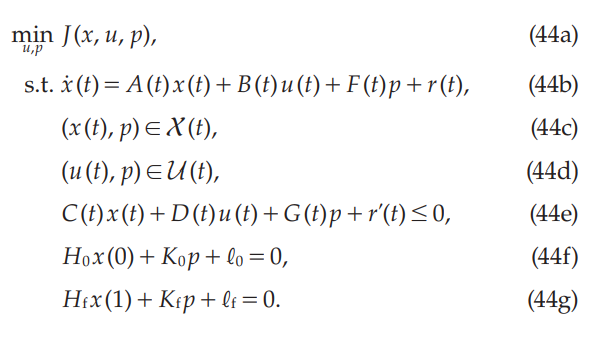

Note: Any jacobian not defined earlier is zero except $r$ and $r'$ which are derived from the other jacobians and dynamics.

### Initial Guess

The SCP algorithms do not require the initial guess to be feasible with respect to the dynamics or nonconvex path constraints, 
but they do require the guess to be feasible with respect to the convex path constraints

State

* r: Straight line interpolation
* v: Constant (from r)
* q: Spherical interpolation
* ω: Constant (from θ)

Control

* T: 80% max thrust, no thrust vectoring: $T_{guess} = 0.8T_{max}\hat b_1$
* γ: Zero vane angle (should never be very large)

In [355]:
"""
    straightline_interpolate(v0, vf, N)

Straight-line interpolation between two points. Compute a straight-line
interpolation between an initial and a final vector, on a grid of N points.

# Arguments
- `v0`: starting vector.
- `vf`: ending vector.
- `N`: number of vectors in between (including endpoints).

# Returns
- `v`: the resulting interpolation (a matrix, k-th column is the k-th vector,
  k=1,...,N).
"""
function straightline_interpolate(v0::RealVector, vf::RealVector, N::Int)::RealMatrix

    # Initialize
    nv = length(v0)
    v = zeros(nv, N)

    # Interpolation grid
    times = LinRange(0.0, 1.0, N)
    t_endpts = [times[1], times[end]]
    v_endpts = hcat(v0, vf)

    for k = 1:N
        v[:, k] = linterp(times[k], v_endpts, t_endpts)
    end

    return v
end

"""
    get_interval(x, grid)

Compute grid bin. Get which grid interval a real number belongs to.

# Arguments
- `x`: the real number.
- `grid`: the discrete grid on the real line.

# Returns
- `k`: the interval of the grid the the real number is in.
"""
function get_interval(x::RealValue, grid::RealVector)::Int
    k = sum(x .> grid)
    if k == 0
        k = 1
    end
    return k
end

"""
    linterp(t, f_cps, t_grid)

Linear interpolation on a grid. Linearly interpolate a discrete function on a
time grid. In other words, get the function value assuming that it is a
continuous and piecewise affine function.

# Arguments
- `t`: the time at which to get the function value.
- `f_cps`: the control points of the function, stored as columns of a matrix.
- `t_grid`: the discrete time nodes.

# Returns
- `f_t`: the function value at time t.
"""
function linterp(
    t::RealValue,
    f_cps::RealArray,
    t_grid::RealVector,
)::Union{RealValue,RealArray}
    t = max(t_grid[1], min(t_grid[end], t)) # Saturate to time grid
    k = get_interval(t, t_grid)
    c = (t_grid[k+1] - t) / (t_grid[k+1] - t_grid[k])
    dimfill = fill(:, ndims(f_cps) - 1)
    f_t = c * f_cps[dimfill..., k] + (1 - c) * f_cps[dimfill..., k+1]
    return f_t
end;

In [356]:
# Terminal state (without mass)
x_f = zeros(6)
x_f[5] = deg2rad(90)

# Control guess
T_guess = 0.4*T_max_ # [N] Initial thrust guess
input_guess(N) = straightline_interpolate([T_guess; 0; T_guess], [T_guess; 0; T_guess], N);

# Parameter guess
v_0, v_f = x_0[3:4], x_f[3:4]
tf_guess = 60;#norm(v_f-v_0 + sqrt.(2 * [0; g_] * x_0[2]), 2)/(T_guess/m_-g_)

# State guess
state_guess(N) = begin
    x_guess = zeros(6, N)
    
    # r_guess
    x_guess[1:2, :] = straightline_interpolate(x_0[1:2], x_f[1:2], N)

    # v_guess
    v_cst = (x_f[1:2] - x_0[1:2]) / tf_guess
    x_guess[3:4, :] .= v_cst
    
    # θ_guess 
    x_guess[5, :] = straightline_interpolate([x_0[5]], [x_f[5]], N)
    
    # ω_guess
    ω_cst = (x_0[5] - x_f[5]) / tf_guess
    x_guess[6, :] .= ω_cst
    
    return x_guess
end;

## SCP Toolbox Code and Solution

### Set Up Problem

In [357]:
pbm = TrajectoryProblem();
algo = :ptr;

# Dimensions
n = length(x)
md = length(u)
d = length(p);
problem_set_dims!(pbm, n, md, d)

# Dynamics
build_func(func) = begin
    vfunc = eval(build_function(func, [x; u; p; c])[1]) 
    bfunc(t, k, x, u, p, pbm) = vfunc([x; u; p; c_])
    return bfunc
end;

problem_set_dynamics!(pbm, build_func(f_n), build_func(A_l), build_func(B_l), build_func(F_l))

# Boundary Conditions
build_bc(func) = begin
    vfunc = eval(build_function(func, [x; x0])[1]) 
    bfunc(x, p, pbm) = vfunc([x; x_0])
    return bfunc
end;

problem_set_bc!(pbm, :ic, build_bc(g_ic), build_bc(H_0))
problem_set_bc!(pbm, :tc, build_bc(g_tc), build_bc(H_f));

# Constraints
problem_set_X!(pbm, (t, k, x, p, pbm, clp) -> begin
        
        state_constraints(t, k, x, p, pbm, clp)
    end)

problem_set_U!(pbm, (t, k, u, p, pbm, clp) -> begin

        control_constraints(t, k, u, p, pbm, clp)
    end)

# Cost Function
#problem_set_terminal_cost!(pbm, (x, p, pbm) -> ϕ(x, p))
problem_set_running_cost!(pbm, algo, (t, k, x, u, p, pbm) -> Γ(x, u, p))

# Initial Guess
problem_set_guess!(pbm, (N, pbm) -> begin
    x = state_guess(N)
    u = input_guess(N)
    p = [tf_guess]
    return x, u, p
end)

# Variable Scaling
rx_range_box = max(x_0[1], 1.0)
ry_range_box = max(x_0[2], 1.0)
vx_range_box = max(abs(x_0[3]), 0.001)
vy_range_box = max(abs(x_0[4]), 0.001)
θ_range_box = deg2rad(90)
ω_range_box = max(abs(x_0[6]), deg2rad(5.0))

thrust_range = (0, T_max_)
gimbal_range = (-δ_max_, δ_max_)

problem_advise_scale!(pbm, :state, 1, (-rx_range_box, rx_range_box))
problem_advise_scale!(pbm, :state, 2, (-ry_range_box, ry_range_box))
problem_advise_scale!(pbm, :state, 3, (-vx_range_box, vx_range_box))
problem_advise_scale!(pbm, :state, 4, (-vy_range_box, vy_range_box))
problem_advise_scale!(pbm, :state, 5, (-θ_range_box, θ_range_box))
problem_advise_scale!(pbm, :state, 6, (-ω_range_box, ω_range_box))

problem_advise_scale!(pbm, :input, 1, thrust_range)
problem_advise_scale!(pbm, :input, 2, thrust_range)
problem_advise_scale!(pbm, :input, 3, thrust_range)

problem_advise_scale!(pbm, :parameter, 1, (tf_guess, tf_guess * 1.5));

### Solve Optimization Problem

Define solver parameters, construct the optimization problem, and print the solution state at each solver iteration

In [373]:
# Parameters
N, Nsub = 20, 20
iter_max = 30
disc_method = FOH
wvc, wtr = 1e1, 1e-1
feas_tol = 5e-3
ε_abs, ε_rel = 1e-5, 1e-4
q_tr = 2
q_exit = 2
#solver, solver_options = Mosek, Dict("QUIET"=>true)  
solver, solver_options = ECOS, Dict("verbose"=>0)
#solver, solver_options = Clarabel, Dict("verbose"=>0)

pars = PTR.Parameters(N, Nsub, iter_max, disc_method, wvc, wtr, ε_abs,
                      ε_rel, feas_tol, q_tr, q_exit, solver, solver_options);

ptr_pbm = PTR.create(pars, pbm)
sol, history = PTR.solve(ptr_pbm);

k  | status   | vd    | vs    | vbc   | J         | ΔJ %      | Δx    | Δu    | Δp    | δ     | dyn | ηx    | ηu    | ηp   
---+----------+-------+-------+-------+-----------+-----------+-------+-------+-------+-------+-----+-------+-------+------
1  | ALMOST_O | 2e-06 | 0e+00 | 4e-11 | 5.84e-01  |           | 1e+00 | 6e-01 | 3e-08 | 1e+00 | F   | 1.28  | 0.85  | 0.00 
2  | OPTIMAL  | 3e-10 | 0e+00 | 4e-12 | 5.35e-01  | 8.32      | 1e-01 | 9e-02 | 6e-12 | 2e-01 | F   | 0.15  | 0.13  | 0.00 
3  | ALMOST_O | 3e-07 | 0e+00 | 6e-12 | 5.29e-01  | 1.14      | 1e-02 | 8e-03 | 1e-07 | 2e-02 | T   | 0.02  | 0.01  | 0.00 
4  | ALMOST_O | 1e-07 | 0e+00 | 1e-10 | 5.28e-01  | 0.12      | 1e-04 | 6e-05 | 3e-09 | 1e-04 | T   | 0.00  | 0.00  | 0.00 
5  | ALMOST_O | 2e-07 | 0e+00 | 3e-11 | 5.28e-01  | 0.00      | 3e-06 | 8e-06 | 4e-08 | 3e-06 | T   | 0.00  | 0.00  | 0.00 


## Plot Solution

In [359]:
_sol = history.subproblems[end].sol

tf = _sol.p[1]
xd = _sol.xd
ud = _sol.ud
vd = _sol.vd
p_sol = _sol.p
td = sol.td*tf

Nc = 100
tc = LinRange(0, tf, Nc)
xc = hcat([sample(sol.xc, t) for t in LinRange(0, 1, Nc)]...)
uc = hcat([sample(sol.uc, t) for t in LinRange(0, 1, Nc)]...)

tf_values = [spbm.sol.p[1] for spbm in history.subproblems]
pushfirst!(tf_values, history.subproblems[1].ref.p[1]);

[tf_guess, p_sol[1]]

2-element Vector{Float64}:
 60.0
 60.000005022338215

The final time guess and final time of the solution are
$$
t_{fguess} = `{julia} round(tf_guess, digits = 3)`s,
t_{f} = `{julia} round(p_sol[1], digits = 3)`s
$$

### No Control

In [360]:
x_0

6-element Vector{Float64}:
 1500.0
 2000.0
   22.22222222222222
  -22.22222222222222
    1.5707963267948966
    0.0

In [361]:
build_f(func) = begin
    vfunc = eval(build_function(func, [x; u; p; c])[1]) 
    bfunc(x, p, t) = vfunc([x; zeros(length(u)); [0]; c_])
    return bfunc
end;

f = build_f(f_)
tspan = (0.0, tf_guess*1.5)
prob = ODEProblem(f, x_0, tspan)
sol = solve(prob, Tsit5(), reltol = 1e-8, abstol = 1e-8, saveat = 0.2);

r_ = stack([sol.u[i][1:2] for i in range(1, length(sol))], dims = 1)
valid_ind = r_[:, 2] .>= 0
r_[valid_ind, :];
ind = sum(valid_ind)
xnc = stack([sol.u[i] for i in range(1, ind)], dims = 1)';

θ_ = xnc[5, :]
b_x = hcat([substitute(C_be, Dict(θ => θ_[i])) * [1, 0] for i in range(1, ind)]...)
b_y = hcat([substitute(C_be, Dict(θ => θ_[i])) * [0, 1] for i in range(1, ind)]...)

2×91 Matrix{Float64}:
 -1.0          -1.0          -1.0          …  -1.0          -1.0
  6.12323e-17   6.12323e-17   6.12323e-17      6.12323e-17   6.12323e-17

[ Info: Saved animation to C:\Users\thatf\OneDrive\Documents\Purdue Classes\AAE 590ACA\AAE590ACA-Stochastic-SCP-Rocket-Landing\SCPToolbox\src\tmp.gif


Plots.AnimatedGif("C:\\Users\\thatf\\OneDrive\\Documents\\Purdue Classes\\AAE 590ACA\\AAE590ACA-Stochastic-SCP-Rocket-Landing\\SCPToolbox\\src\\tmp.gif")
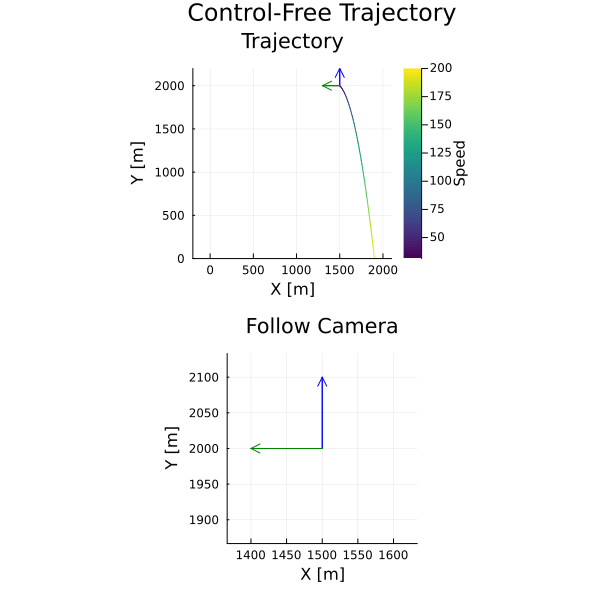

In [362]:
Plots.gr()

velocity = [norm(xnc[3:4, i]) for i in range(1, ind)]

a = Animation()

y_max = max(xnc[2, :]...)
x_lim = (min(min(xnc[1, :]...) - y_max / 10, -y_max / 10), max(xnc[1, :]...) + y_max / 10, y_max / 10)

xs = LinRange(x_lim[1], x_lim[2], 100)
glide(x) = abs(x) * tan(γ_gs_)
ys = [glide(x) for x in xs]

for i in 1:(ind)

    l = @layout [a; b]

    p3 = Plots.plot(xnc[1, :], xnc[2, :], lc=:viridis, line_z=velocity, label = "", colorbar_title = "Speed")
    Plots.quiver!([xnc[1, i]], [xnc[2, i]], quiver = ([b_x[1, i]], [b_x[2, i]]) .* y_max ./ 10, aspect_ratio=:equal, color = :blue, label = "b_x")
    Plots.quiver!([xnc[1, i]], [xnc[2, i]], quiver = ([b_y[1, i]], [b_y[2, i]]) .* y_max ./ 10, aspect_ratio=:equal, color = :green, label = "b_y")    
    Plots.title!("Trajectory")
    Plots.xlabel!("X [m]")
    Plots.ylabel!("Y [m]")
    Plots.xlims!((x_lim[1], x_lim[2]))
    Plots.ylims!((0, y_max * 1.1))

    p4 = Plots.quiver([xnc[1, i]], [xnc[2, i]], quiver = ([b_x[1, i]], [b_x[2, i]]) .* y_max ./ 20, aspect_ratio=:equal, color = :blue, label = "b_x")
    Plots.quiver!([xnc[1, i]], [xnc[2, i]], quiver = ([b_y[1, i]], [b_y[2, i]]) .* y_max ./ 20, aspect_ratio=:equal, color = :green, label = "b_y")
    
    Plots.xlims!((xnc[1, i] - y_max / 15, xnc[1, i] + y_max / 15))
    Plots.ylims!((xnc[2, i] - y_max / 15, xnc[2, i] + y_max / 15))
    Plots.title!("Follow Camera")
    Plots.xlabel!("X [m]")
    Plots.ylabel!("Y [m]")
    
    plt = Plots.plot(p3, p4, layout = l, plot_title="Control-Free Trajectory", widths = (3/4, 1/4), size = (600, 600), aspect_ratio = :equal, margin = 1mm)

    
    frame(a, plt)
end
	
gif(a, fps = 10)
#gif(a, "Trajectory_and_Orientation.gif", fps = 15) 

### Initial Guess

[ Info: Saved animation to C:\Users\thatf\OneDrive\Documents\Purdue Classes\AAE 590ACA\AAE590ACA-Stochastic-SCP-Rocket-Landing\SCPToolbox\src\Trajectory_and_Orientation.gif


Plots.AnimatedGif("C:\\Users\\thatf\\OneDrive\\Documents\\Purdue Classes\\AAE 590ACA\\AAE590ACA-Stochastic-SCP-Rocket-Landing\\SCPToolbox\\src\\Trajectory_and_Orientation.gif")
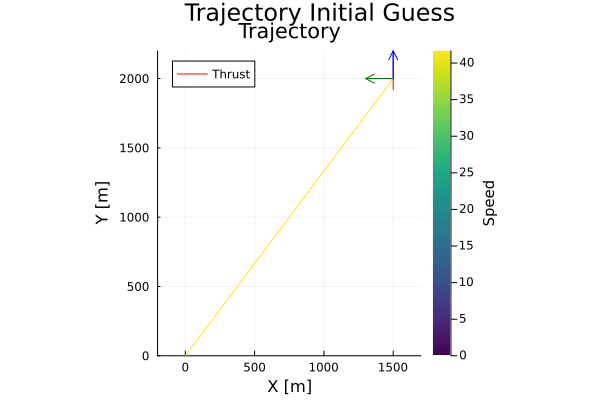

In [363]:
xi = state_guess(length(tc))
ui = input_guess(length(tc))

# define a function that returns a Plots.Shape
rectangle(w, h, x, y, bx) = begin 
    P = [-w/2 w/2 w/2 -w/2; 0 0 h h]
    by = [0 1; -1 0] * bx
    P_prime = hcat([[0 -1; 1 0] * [bx by] * P[:, i] for i in range(1, 4)]...)
    P_prime = P_prime .+ [x; y]
    
    return Shape(P_prime[1, :], P_prime[2, :])
end

rectangle_norot(w, h, x, y) = begin 
    P = [-w/2 w/2 w/2 -w/2; 0 0 h h]
    P = P .+ [x; y]
    
    return Shape(P[1, :], P[2, :])
end

θ_ = xi[5, :]
b_x = hcat([substitute(C_be, Dict([θ => θ_[i]])) * [1, 0] for i in range(1, length(tc))]...)
b_y = hcat([substitute(C_be, Dict([θ => θ_[i]])) * [0, 1] for i in range(1, length(tc))]...)

T_ = ui[1:2, :]
T_e = hcat([substitute(C_be, Dict([θ => θ_[i]])) * T_[:, i] for i in range(1, length(tc))]...)

Plots.gr()

velocity = [norm(xi[3:4, i]) for i in range(1, Nc)]

a = Animation()

y_max = max(xi[2, :]...)
x_lim = (min(min(xi[1, :]...) - y_max / 10, -y_max / 10), max(xi[1, :]...) + y_max / 10, y_max / 10)

xs = LinRange(x_lim[1], x_lim[2], 100)
glide(x) = abs(x) * tan(γ_gs_)
ys = [glide(x) for x in xs]

for i in 1:length(tc)

    l = @layout [a]

    p3 = Plots.plot(xi[1, :], xi[2, :], lc=:viridis, line_z=velocity, label = "", colorbar_title = "Speed")
    Plots.quiver!([xi[1, i]], [xi[2, i]], quiver = ([b_x[1, i]], [b_x[2, i]]) .* y_max ./ 10, aspect_ratio=:equal, color = :blue, label = "b_x")
    Plots.quiver!([xi[1, i]], [xi[2, i]], quiver = ([b_y[1, i]], [b_y[2, i]]) .* y_max ./ 10, aspect_ratio=:equal, color = :green, label = "b_y")
    Plots.plot!([xi[1, i], xi[1, i] - T_e[1, i] / T_max_ * y_max ./ 10], [xi[2, i], xi[2, i] - T_e[2, i] / T_max_ * y_max ./ 10], color = :red, label = "Thrust", axpect_ratio=:equal)
    Plots.title!("Trajectory")
    Plots.xlabel!("X [m]")
    Plots.ylabel!("Y [m]")
    Plots.xlims!((x_lim[1], x_lim[2]))
    Plots.ylims!((0, y_max * 1.1))

    plt = Plots.plot(p3, layout = l, plot_title="Trajectory Initial Guess", size = (600, 400), aspect_ratio = :equal, margin = 1mm)

    frame(a, plt)
end
	
#gif(a, fps = 15)
gif(a, "Trajectory_and_Orientation.gif", fps = 15)

### Solution Gif

In [364]:
# define a function that returns a Plots.Shape
rectangle(w, h, x, y, bx) = begin 
    P = [-w/2 w/2 w/2 -w/2; 0 0 h h]
    by = [0 1; -1 0] * bx
    P_prime = hcat([[0 -1; 1 0] * [bx by] * P[:, i] for i in range(1, 4)]...)
    P_prime = P_prime .+ [x; y]
    
    return Shape(P_prime[1, :], P_prime[2, :])
end

rectangle_norot(w, h, x, y) = begin 
    P = [-w/2 w/2 w/2 -w/2; 0 0 h h]
    P = P .+ [x; y]
    
    return Shape(P[1, :], P[2, :])
end

θ_ = xc[5, :]
b_x = hcat([substitute(C_be, Dict([θ => θ_[i]])) * [1, 0] for i in range(1, length(tc))]...)
b_y = hcat([substitute(C_be, Dict([θ => θ_[i]])) * [0, 1] for i in range(1, length(tc))]...)

T_ = uc[1:2, :]
T_e = hcat([substitute(C_be, Dict([θ => θ_[i]])) * T_[:, i] for i in range(1, length(tc))]...)

2×100 Matrix{Float64}:
 37347.5        31314.0        …  -28536.8        -40509.9
     3.04171e5      2.84727e5          4.81551e5       4.98352e5

[ Info: Saved animation to C:\Users\thatf\OneDrive\Documents\Purdue Classes\AAE 590ACA\AAE590ACA-Stochastic-SCP-Rocket-Landing\SCPToolbox\src\Trajectory_and_Orientation.gif


Plots.AnimatedGif("C:\\Users\\thatf\\OneDrive\\Documents\\Purdue Classes\\AAE 590ACA\\AAE590ACA-Stochastic-SCP-Rocket-Landing\\SCPToolbox\\src\\Trajectory_and_Orientation.gif")
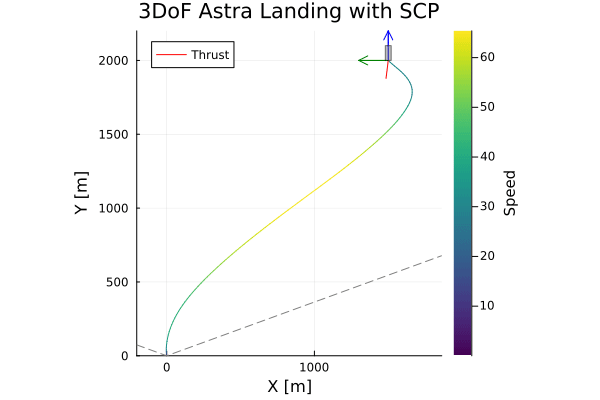

In [365]:
Plots.gr()

velocity = [norm(xc[3:4, i]) for i in range(1, length(tc))]

a = Animation()

y_max = max(xc[2, :]...)
x_lim = (min(min(xc[1, :]...) - y_max / 10, -y_max / 10), max(max(xc[1, :]...) + y_max / 10, y_max / 10))

xs = LinRange(x_lim[1], x_lim[2], 100)
glide(x) = abs(x) * tan(γ_gs_)
ys = [glide(x) for x in xs]

function decimate_ticks(p, axis)
    zt = axis == :x ? only(xticks(p)) : only(yticks(p))
    n, k = length(zt[1]), findfirst(≈(0), zt[1])
    ix = isnothing(k) ? (1:2:n) : sort([k:-2:1; (k+2):2:n])
    return (zt[1][ix], zt[2][ix])
end

for i in 1:length(tc)

    l = @layout [a; b c; d]

    p1 = Plots.plot(xc[1, :], xc[2, :], lc=:viridis, line_z=velocity, label = "", colorbar_title = "Speed")
    Plots.quiver!([xc[1, i]], [xc[2, i]], quiver = ([b_x[1, i]], [b_x[2, i]]) .* y_max ./ 10, aspect_ratio=:equal, color = :blue, label = "b_x")
    Plots.quiver!([xc[1, i]], [xc[2, i]], quiver = ([b_y[1, i]], [b_y[2, i]]) .* y_max ./ 10, aspect_ratio=:equal, color = :green, label = "b_y")
    Plots.plot!([xc[1, i], xc[1, i] - T_e[1, i] / T_max_ * y_max ./ 10], [xc[2, i], xc[2, i] - T_e[2, i] / T_max_ * y_max ./ 10], color = :red, label = "Thrust", axpect_ratio=:equal, ylim=(0, y_max*1.1), xlim=x_lim)
    Plots.plot!(rectangle(y_max / 50,y_max / 20,xc[1, i],xc[2, i], [b_x[1, i]; b_x[2, i]]), label = "", opacity=.5, color = :gray)
    Plots.plot!(LinRange(x_lim[1], x_lim[2], 100), abs.(LinRange(x_lim[1], x_lim[2], 100)) * tan(γ_gs_), linestyle = :dash, label = "", color = :gray, xticks=decimate_ticks(p1, :x))
    Plots.title!("3DoF Astra Landing with SCP")
    Plots.xlabel!("X [m]")
    Plots.ylabel!("Y [m]")

    
    plt = Plots.plot(p1, layout = l, widths = (1), size = (600, 400), aspect_ratio = :equal, margin = 1mm)

    
    frame(a, plt)
end
	
#gif(a,fps = 15)
gif(a, "Trajectory_and_Orientation.gif", fps = 15)

### State Plots

The solver solved the problem by optimizing over the discrete trajectory. To check if the solution is still valid in the continuous case, the solution is propagated using a much finer time step to approximate the continuous trajectory. If the solution is good, the two trajectories should match well.

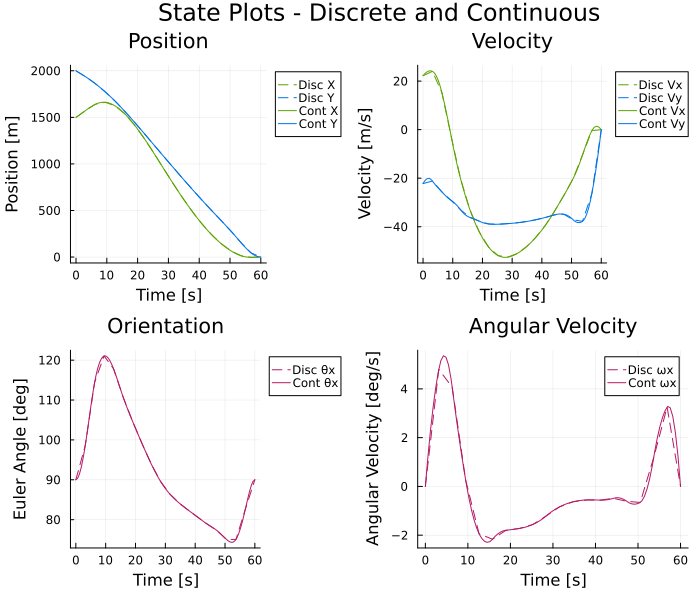

In [366]:
Plots.gr()

l = @layout [a b; c d]

plt_r = Plots.plot(td, xd[1, :], label = "Disc X", color = "#5ba300", linestyle = :dash)
Plots.plot!(td, xd[2, :], label = "Disc Y", color = "#0073e6", linestyle = :dash)
Plots.plot!(tc, xc[1, :], label = "Cont X", color = "#5ba300")
Plots.plot!(tc, xc[2, :], label = "Cont Y", color = "#0073e6", legend = :outertopright)
Plots.title!("Position")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Position [m]")

plt_v = Plots.plot(td, xd[3, :], label = "Disc Vx", color = "#5ba300", linestyle = :dash)
Plots.plot!(td, xd[4, :], label = "Disc Vy", color = "#0073e6", linestyle = :dash)
Plots.plot!(tc, xc[3, :], label = "Cont Vx", color = "#5ba300")
Plots.plot!(tc, xc[4, :], label = "Cont Vy", color = "#0073e6", legend = :outertopright)
Plots.title!("Velocity")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Velocity [m/s]")

plt_θ = Plots.plot(td, xd[5, :] * 180 / pi, label = "Disc θx", color = "#b51963", linestyle = :dash)
Plots.plot!(tc, xc[5, :] * 180 / pi, label = "Cont θx", color = "#b51963", legend = :outertopright)
Plots.title!("Orientation")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Euler Angle [deg]")

plt_ω = Plots.plot(td, xd[6, :] * 180 / pi, label = "Disc ωx", color = "#b51963", linestyle = :dash)
Plots.plot!(tc, xc[6, :] * 180 / pi, label = "Cont ωx", color = "#b51963")
Plots.title!("Angular Velocity")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Angular Velocity [deg/s]")

plt = Plots.plot(plt_r, plt_v, plt_θ, plt_ω, layout = l, widths = (1/2, 1/2, 1/2, 1/2), plot_title="State Plots - Discrete and Continuous", size = (700, 600), margin = 1mm)
#savefig(plt, "State_plots.png") # save the fig referenced by plot_ref as filename_string (such as "output.png")

### Control Plots

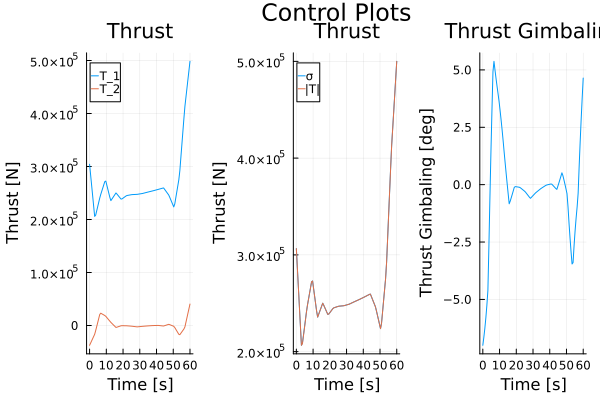

In [367]:
Plots.gr()

l = @layout [a b c]

plt_T = Plots.plot(tc, uc[1, :], label = "T_1")
Plots.plot!(tc, uc[2, :], label = "T_2")
Plots.title!("Thrust")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Thrust [N]")

plt_T_ck = Plots.plot(tc, uc[3, :], label = "σ")
Plots.plot!(tc, sqrt.(uc[1, :] .^ 2 + uc[2, :] .^ 2), label = "|T|")
Plots.title!("Thrust")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Thrust [N]")

gimbal = atan.(uc[2, :], uc[1, :]);

plt_δ = Plots.plot(tc, gimbal * 180 / pi, label = "")
Plots.title!("Thrust Gimbaling")
Plots.xlabel!("Time [s]")
Plots.ylabel!("Thrust Gimbaling [deg]")

plt = Plots.plot(plt_T, plt_T_ck, plt_δ, layout = l, widths = (1/2, 1/2), plot_title="Control Plots", size = (600, 400), margin = 1.5mm)

### Interactive 3D Trajectory View

Ignore the error from the next plot

In [140]:
#Xd = LinRange(x_lim[1], x_lim[2], 100)' .* ones(100)
#Yd = ones(100)' .* LinRange(y_lim[1], y_lim[2], 100)
#Zd = sqrt.((Xd .^ 2 + Yd .^ 2)) * tan(γ_gs_);
#
#T_ = uc[1:3, :]
#θ_ = xc[7:9, :]
#T_e = hcat([substitute(C_be, Dict([θ[1] => θ_[1, i], θ[2] => θ_[2, i], θ[3] => θ_[3, i]]))' * T_[:, i] for i in range(1, length(tc))]...)
#
#
#Plots.plotlyjs()   # set the backend to Plotly
#
#Plots.quiver(xc[1, :], xc[2, :], xc[3, :], quiver = (b_x[1, :], b_x[2, :], b_x[3, :]) .* z_max ./ 40, aspect_ratio=:equal, size = (500, 800), label = "Body X")
#Plots.quiver!(xc[1, :], xc[2, :], xc[3, :], quiver = (b_y[1, :], b_y[2, :], b_y[3, :]) .* z_max ./ 40, aspect_ratio=:equal, label = "Body Y")
#Plots.quiver!(xc[1, :], xc[2, :], xc[3, :], quiver = (b_z[1, :], b_z[2, :], b_z[3, :]) .* z_max ./ 40, aspect_ratio=:equal, label = "Body Z")
#Plots.quiver!(xc[1, :], xc[2, :], xc[3, :], quiver = (-T_e[1, :], -T_e[2, :], -T_e[3, :]) ./ T_max_ .* z_max ./ 20, axpect_ratio=:equal, scene_aspectmode="cube", label = "Thrust")
#Plots.surface!(Xd, Yd, Zd, aspect_ratio=:equal, colorbar = false, scene_aspectmode="cube", alpha = 0.5) # Glideslope
#Plots.title!("Interactive Trajectory")
#Plots.xlabel!("X")
#Plots.ylabel!("Y")
#Plots.zlabel!("Z")